In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torch.functional as F
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib notebook

### Load champion corpus

In [2]:
def tokenize_corpus(corpus_path = 'data/champion_list_master_dataset.xlsx'):
    corpus = pd.read_excel(corpus_path, header = 0, index_col = False)
    tokens = [list(x.iloc[:7][~pd.isnull(x.iloc[:7])]) for _, x in corpus.iterrows()]
    return tokens

tokenized_corpus = tokenize_corpus()

In [3]:
for li in range(len(tokenized_corpus)): 
    tokenized_corpus[li][-1] = str(tokenized_corpus[li][-1])
tokenized_corpus

[['Brand', 'Debonair', 'Arcanist', '1.0'],
 ['Caitlyn', 'Enforcer', 'Sniper', '1.0'],
 ['Camille', 'Clockwork', 'Challenger', '1.0'],
 ['Darius', 'Syndicate', 'Bodyguard', '1.0'],
 ['Ezreal', 'Scrap', 'Innovator', '1.0'],
 ['Illaoi', 'Mercenary', 'Bruiser', '1.0'],
 ['Jarvan IV', 'Hextech', 'Striker', '1.0'],
 ['Kassadin', 'Mutant', 'Scholar', '1.0'],
 ['Nocturne', 'Hextech', 'Assassin', '1.0'],
 ['Poppy', 'Yordle', 'Bodyguard', '1.0'],
 ['Singed', 'Chemtech', 'Innovator', '1.0'],
 ['Twitch', 'Chemtech', 'Assassin', '1.0'],
 ['Ziggs', 'Yordle', 'Scrap', 'Arcanist', '1.0'],
 ['Ashe', 'Syndicate', 'Sniper', '2.0'],
 ['Blitzcrank', 'Scrap', 'Bodyguard', '2.0'],
 ['Corki', 'Yordle', 'Twinshot', '2.0'],
 ['Lulu', 'Yordle', 'Enchantor', '2.0'],
 ['Quinn', 'Mercenary', 'Challengar', '2.0'],
 ["Rek'Sai", 'Mutant', 'Striker', 'Bruiser', '2.0'],
 ['Sejuani', 'Hextech', 'Enforcer', 'Brusier', '2.0'],
 ['Swain', 'Hextech', 'Arcanist', '2.0'],
 ['Syndra', 'Debonair', 'Scholar', '2.0'],
 ['Talon', '

In [4]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [5]:
champions = [l[0] for l in tokenized_corpus]
champions_idx = [word2idx.get(c) for c in champions]
traits = [l for l in vocabulary if l not in champions]
traits_idx = [word2idx.get(t) for t in traits]

# Create list of traits including champs
champ_in_traits = []
for t in traits:
    champ_in_traits.append([word2idx.get(l[0]) for l in tokenized_corpus if t in l])
    
traits2champ = {t:champ_in_traits[i] for (i, t) in enumerate(traits)}

In [32]:
len(champions)

85

In [6]:
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    center_word = indices[0]
    
    # for each word, threated as center word
    for curr_word in indices[1:]:
        idx_pairs.append((center_word, curr_word))
        idx_pairs.append((curr_word, center_word))
        
#        # for each window position
#         for w in range(-window_size, window_size + 1):
#             context_word_pos = center_word_pos + w
#             # make soure not jump out sentence
#             if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
#                 continue
#             context_word_idx = indices[context_word_pos]
#             idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [7]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [8]:
embedding_dims = 2
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 120
learning_rate = 0.01

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 5.762834810274692
Loss at epo 10: 4.984872805678155
Loss at epo 20: 4.762479720036845
Loss at epo 30: 4.626081955826972
Loss at epo 40: 4.505542487644952
Loss at epo 50: 4.385955402427468
Loss at epo 60: 4.2708741093962646
Loss at epo 70: 4.1683544950051745
Loss at epo 80: 4.081514995945387
Loss at epo 90: 4.008106075288835
Loss at epo 100: 3.944484943200734
Loss at epo 110: 3.8882557116756753


In [9]:
W2_np = W2.detach().numpy()

In [10]:
traits2champ

{'Debonair': [0, 46, 47, 58, 72, 95],
 'Arcanist': [0, 32, 45, 60, 66, 68, 94, 100, 117],
 '1.0': [0, 4, 7, 10, 13, 16, 19, 22, 25, 27, 29, 31, 32],
 'Enforcer': [4, 43, 80, 84, 118],
 'Sniper': [4, 33, 61, 74, 95, 106, 107],
 'Clockwork': [7, 49, 74, 76],
 'Challenger': [7, 65, 72, 87, 118, 121],
 'Syndicate': [10, 33, 50, 62, 68, 71, 100, 113, 122],
 'Bodyguard': [10, 27, 35, 58, 71, 82],
 'Scrap': [13, 32, 35, 54, 73, 86, 108, 116],
 'Innovator': [13, 29, 49, 54, 78, 84, 109],
 'Mercenary': [16, 40, 55, 61, 90],
 'Bruiser': [16, 42, 51, 67, 80, 90, 108, 115],
 'Hextech': [19, 25, 43, 45, 59, 70, 79],
 'Striker': [19, 42, 56, 73, 79],
 'Mutant': [22, 42, 51, 60, 75, 87, 106, 115],
 'Scholar': [22, 46, 50, 77, 88, 109, 110, 111, 116, 123],
 'Assassin': [25, 31, 47, 54, 75, 105, 113, 122],
 'Yordle': [27, 32, 36, 38, 56, 66, 107, 109],
 'Chemtech': [29, 31, 48, 65, 67, 77, 94, 110, 115, 120],
 '2.0': [33, 35, 36, 38, 40, 42, 43, 45, 46, 47, 48, 49, 50],
 'Twinshot': [36, 55, 59, 86, 10

<IPython.core.display.Javascript object>


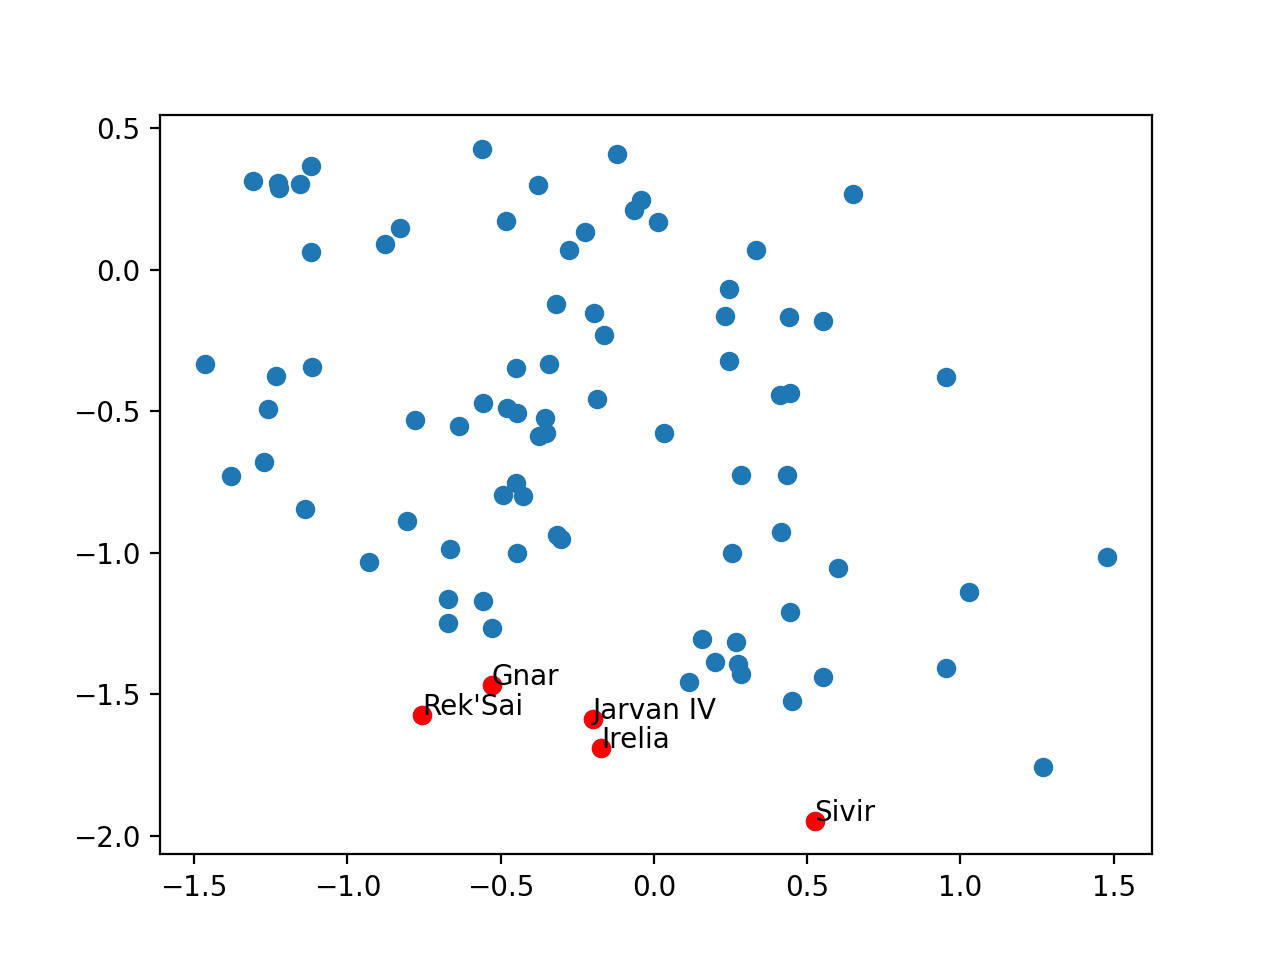

In [31]:
fig = plt.figure()
ax = plt.axes()

champ_with_traits = traits2champ.get('Striker')

ax.scatter(W2_np[champions_idx,0], W2_np[champions_idx,1])
ax.scatter(W2_np[champ_with_traits,0], W2_np[champ_with_traits,1], c='Red')

for i in champ_with_traits:
    ax.text(W2_np[i,0], W2_np[i,1], idx2word.get(i))

# ax.scatter(W2_np[:,0], W2_np[:,1])
# ax.scatter(W2_np[traits_idx,0], W2_np[traits_idx,1], c='Green')

# for i in range(W2_np.shape[0]):
#     ax.text(W2_np[i,0], W2_np[i,1], idx2word.get(i))

In [12]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(W2_np[champions_idx,0], W2_np[champions_idx,1], W2_np[champions_idx ,2])
ax.scatter3D(W2_np[YordleIdx,0], W2_np[YordleIdx,1], W2_np[YordleIdx,2], c='Red')

# for i in champions_idx:
#     ax.text(W2_np[i,0], W2_np[i,1], W2_np[i,2], idx2word.get(i))

<IPython.core.display.Javascript object>

IndexError: index 2 is out of bounds for axis 1 with size 2